In [444]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# check device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)
print(torch.__version__)

cuda
1.2.0


In [445]:
# parameters
RANDOM_SEED = 42 #42
LEARNING_RATE = 0.001 #0.001
BATCH_SIZE = 32 #32
N_EPOCHS = 5 #10

IMG_SIZE = 32 #32
N_CLASSES = 18 #20

In [446]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
            
    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def plot_accuracy(train_accuracies, valid_accuracies):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_accuracies = np.array(train_accuracies) 
    valid_accuracies = np.array(valid_accuracies)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_accuracies, color='blue', label='Training accuracy') 
    ax.plot(valid_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [447]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [448]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    #Y_true = []
    #Y_pred = []
    for X, y_true in valid_loader:
        
        X = X.to(device)
        #Y_true.append(y_true)
        y_true = y_true.to(device)
        
        
        # Forward pass and record loss
        y_hat, _ = model(X) 
        #Y_pred.append(y_hat)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)
        
    #print("Y_pred[0] : ", Y_pred[0])
    #print("Y_true[0] : ", Y_true[0])
    #print("sum(Y_true) : ", sum(Y_true))

    #print(confusion_matrix(Y_true[0],Y_true[0], labels=list(range(20))))
    epoch_loss = running_loss / len(valid_loader.dataset)
    
        
    return model, epoch_loss

In [454]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            
            train_accuracies.append(train_acc)
            valid_accuracies.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
            
        torch.save(model.state_dict(), './results/LeNet300model.pth')
        torch.save(optimizer.state_dict(), './results/LeNet300optimizer.pth')
    plot_losses(train_losses, valid_losses)
    plot_accuracy(train_accuracies, valid_accuracies)
   
    #print(confusion_matrix(Y_true[0],Y_true[0], labels=list(range(N_CLASSES))))
    return model, optimizer, (train_losses, valid_losses)

In [459]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root='train',
                        transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.10793465,), (0.2079014,))])),
    batch_size=BATCH_SIZE, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(root='test',  transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.108241245,), (0.20810026,))])),
    batch_size=BATCH_SIZE, shuffle=True)

In [460]:
class LeNet300(nn.Module):

    def __init__(self, n_classes):
        super(LeNet300, self).__init__()
        
        self.feature=nn.Sequential(
            nn.Linear(32*32,300),
            nn.ReLU(),
            nn.Linear(300,100),
            nn.ReLU(),
            nn.Linear(100,n_classes)
        )
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.feature(x)
        probs = F.log_softmax(x, dim=1)
        return x, probs

In [461]:
torch.manual_seed(RANDOM_SEED)

model = LeNet300(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

15:19:00 --- Epoch: 0	Train loss: 0.0820	Valid loss: 0.0173	Train accuracy: 99.44	Valid accuracy: 99.47
15:19:50 --- Epoch: 1	Train loss: 0.0199	Valid loss: 0.0194	Train accuracy: 99.58	Valid accuracy: 99.52
15:20:39 --- Epoch: 2	Train loss: 0.0150	Valid loss: 0.0205	Train accuracy: 99.53	Valid accuracy: 99.50
15:21:29 --- Epoch: 3	Train loss: 0.0103	Valid loss: 0.0001	Train accuracy: 100.00	Valid accuracy: 100.00
15:22:19 --- Epoch: 4	Train loss: 0.0000	Valid loss: 0.0000	Train accuracy: 100.00	Valid accuracy: 100.00


'\nwith torch.no_grad():\n    for i, data in enumerate(valid_loader, 0):\n        t_image, mask = data\n        t_image, mask = t_image.to(device), mask.to(device)\n\n        output = model(t_image)\n        pred = torch.exp(output[0])\n        pred = torch.argmax(pred, dim = 1)\n        conf_matrix = sklearn.metrics.confusion_matrix(pred, mask)\n        print(conf_matrix)\n'

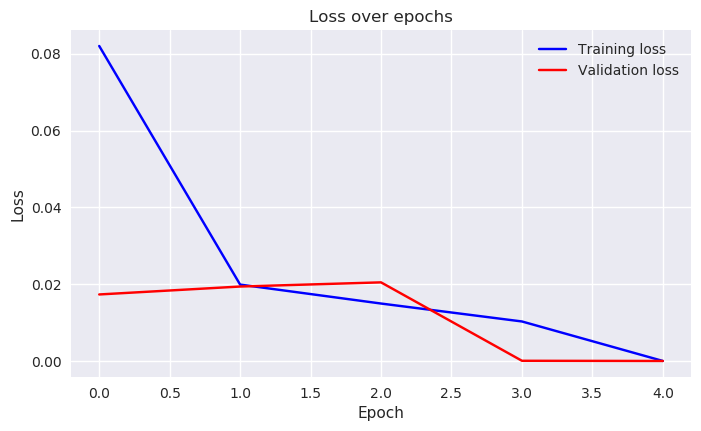

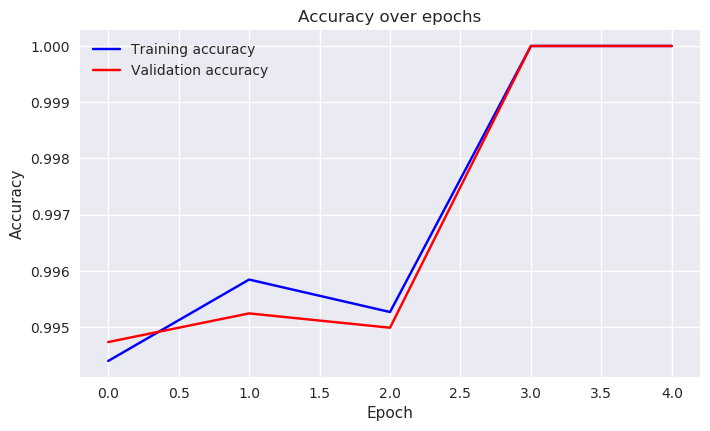

In [462]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)
'''
with torch.no_grad():
    for i, data in enumerate(valid_loader, 0):
        t_image, mask = data
        t_image, mask = t_image.to(device), mask.to(device)

        output = model(t_image)
        pred = torch.exp(output[0])
        pred = torch.argmax(pred, dim = 1)
        conf_matrix = sklearn.metrics.confusion_matrix(pred, mask)
        print(conf_matrix)
'''